In [1]:
# global helpers
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('./functions'))
sys.path.insert(0, module_path)


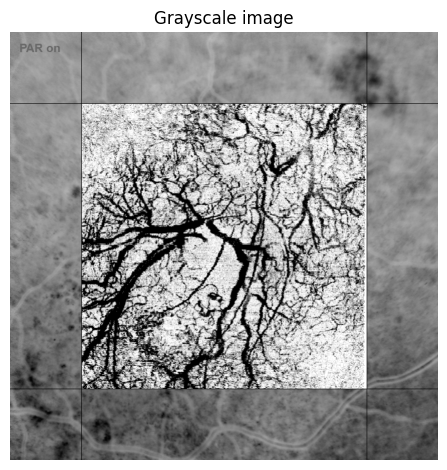

In [2]:
# Constants 
from utils import npToImg, count_images_in_folder
from variables import dataset

# Import the necessary libraries
from PIL import Image
import numpy as np
from scipy.signal import lfilter

# keep all constants related to dataset
vars = dataset['ie']
crop_h1 = vars["crop_h1"]
crop_h2 = vars["crop_h2"]
crop_w1 = vars["crop_w1"]
crop_w2 = vars["crop_w2"]

fp_dist         = vars["fp_dist"]
fp_prominence   = vars["fp_prominence"]
fp_wlen         = vars["fp_wlen"]
fp_rel_height   = vars["fp_rel_height"]
fp_width        = vars["fp_width"]
fp_height       = vars["fp_height"]

cc_path_length  = vars["cc_path_length"]
cc_tresh        = vars["cc_tresh"]
cc_length       = vars["cc_length"]

test_point      = vars["test_point"]

# at what thickness images were exported from HEYEX2
thickness = 4

pth = 20
mask_pth = 200

base_dir = f'oct/{vars["path"]}/'
out_dir = f'oct/{vars["path"]}/out/'

img_no = count_images_in_folder(base_dir) - 1

# lfilter contrast / smoothing the wave
cc_n = 3  # the larger n is, the smoother curve will be
cc_b = [0.95 / cc_n] * cc_n
cc_a = 1

# 1px = 5.7 x 5.7 (radial) x 3.9 (axial)
px_vol = 5.7 * 5.7 * 3.9
# px_vol = 5.7 * 5.7 * (thickness / img_no)

# load the image as grayscale and convert into numpy array
img = Image.open(base_dir + '0.png').convert('L') # for some reason, the image is inverted

numpy_image = np.array(img)

# mark neovascularization area:
for i in range(numpy_image[0].shape[0]):
    numpy_image[crop_h1][i] = 255
    numpy_image[crop_h2][i] = 255
    
for i in range(numpy_image.shape[1]):
    numpy_image[i][crop_w1] = 255
    numpy_image[i][crop_w2] = 255
    
npToImg([[numpy_image, "Grayscale image"]])


## Preprocess the image -----------

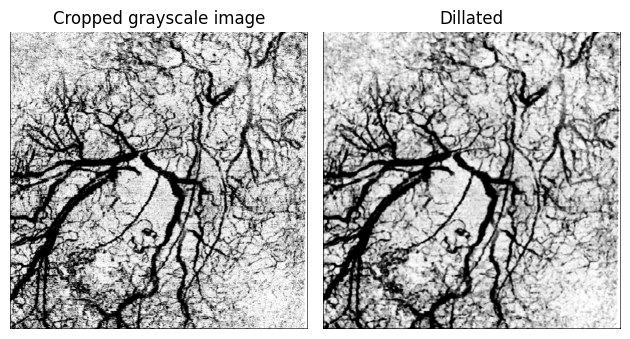

0 (513, 513)


In [3]:
from utils import crop, npSaveImg
from scipy.ndimage import median_filter

numpydata = crop(numpy_image, crop_w1, crop_w2, crop_h1, crop_h2)

numpydilated = numpydata.copy()
numpydilated = median_filter(numpydilated, 3)

npToImg([[numpydata, "Cropped grayscale image"], [numpydilated, "Dillated"]])
npSaveImg(numpydilated, out_dir, "0")

arrReshaped = numpydilated.reshape(numpydilated.shape[0], -1)
np.savetxt(out_dir + 'numpydilated.csv', arrReshaped)

width = numpydilated.shape[0]
height = numpydilated.shape[1]

## Find peaks -----------

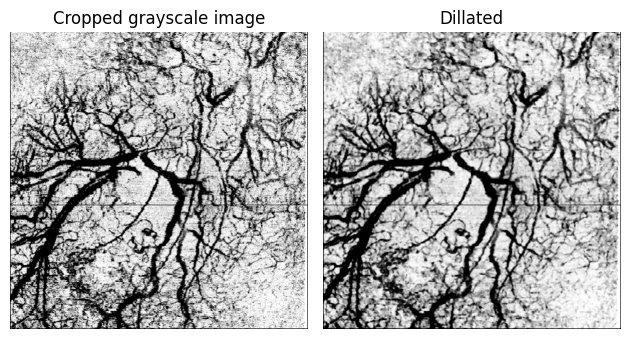

In [4]:
test_image = numpydata.copy()
test_dilated = numpydilated.copy()
test_image[test_point - 1, :] = 255
test_dilated[test_point - 1, :] = 255

npToImg([[test_image, "Cropped grayscale image"], [test_dilated, "Dillated"]])

{'peak_heights': array([124.13333333, 120.65      , 242.25      , 113.36666667,
       242.25      ,  73.78333333, 122.86666667, 217.86666667,
       215.65      , 242.25      , 217.55      , 204.25      ,
       229.58333333, 237.5       , 215.96666667, 207.73333333,
        90.88333333, 113.05      , 152.31666667, 125.08333333]), 'prominences': array([ 91.2       ,  58.9       , 180.5       ,  57.95      ,
       210.26666667,  44.65      ,  48.45      , 148.83333333,
       203.93333333, 208.68333333, 184.93333333, 150.73333333,
       176.06666667, 200.45      , 145.35      , 181.13333333,
        51.61666667,  94.05      , 132.36666667, 112.1       ]), 'left_bases': array([ 18,  29,  41,  71,  86, 128, 148, 155, 221, 271, 305, 316, 346,
       367, 377, 394, 421, 421, 458, 487]), 'right_bases': array([ 29,  41,  84,  86, 127, 148, 165, 197, 242, 305, 316, 346, 367,
       394, 394, 421, 431, 456, 487, 511]), 'widths': array([ 7.1952381 ,  6.27181818, 19.19551282,  6.59699153, 23.1

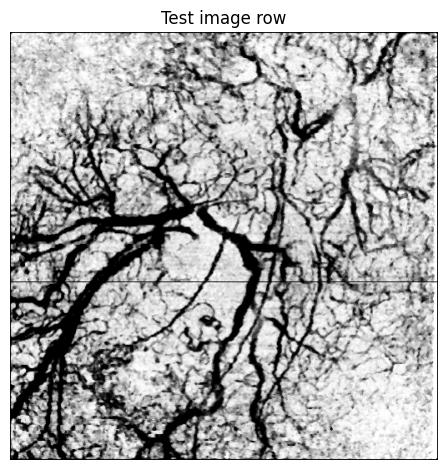

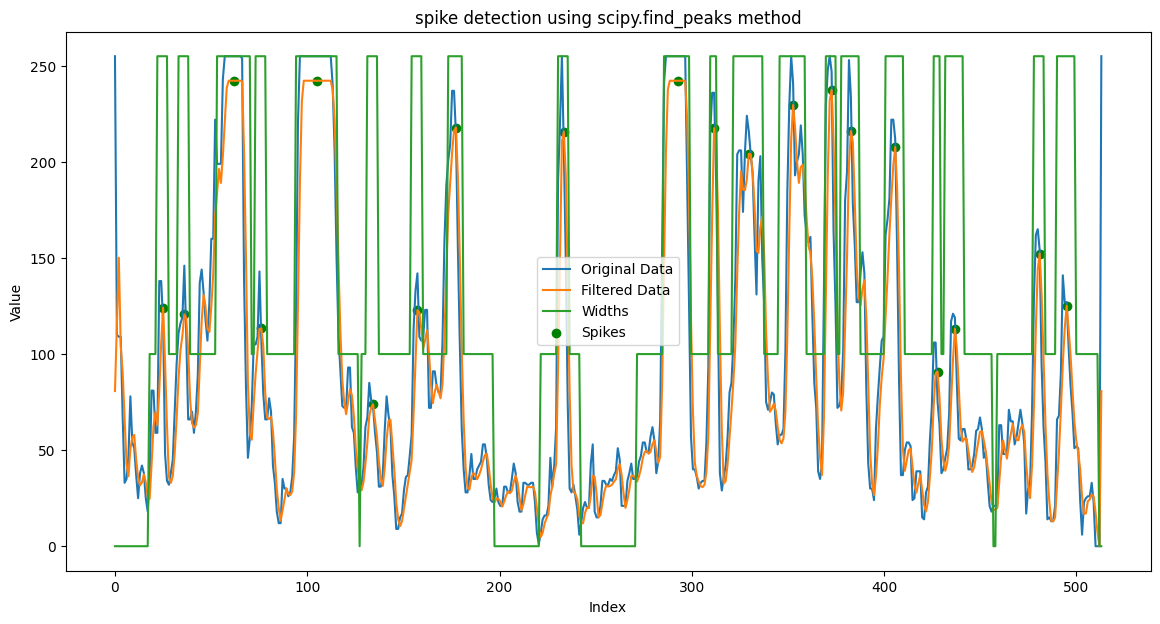

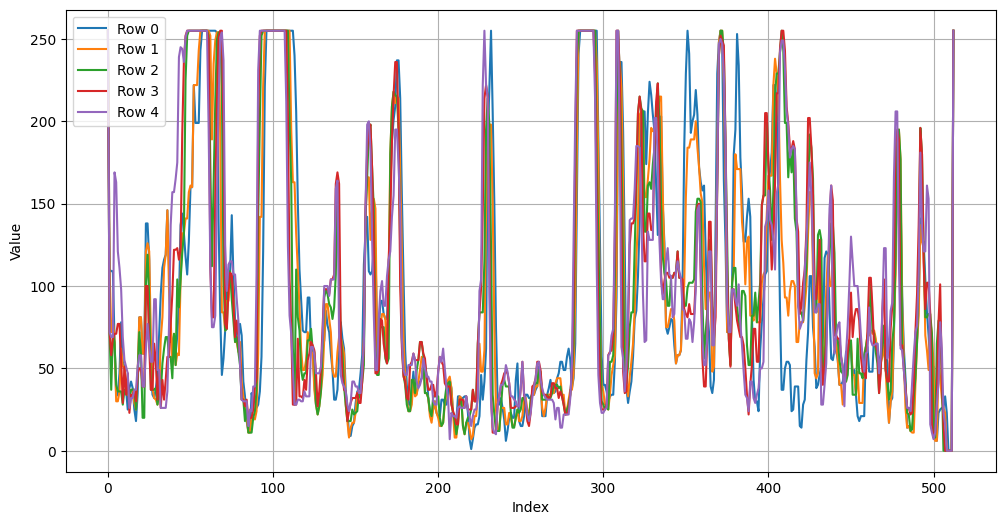

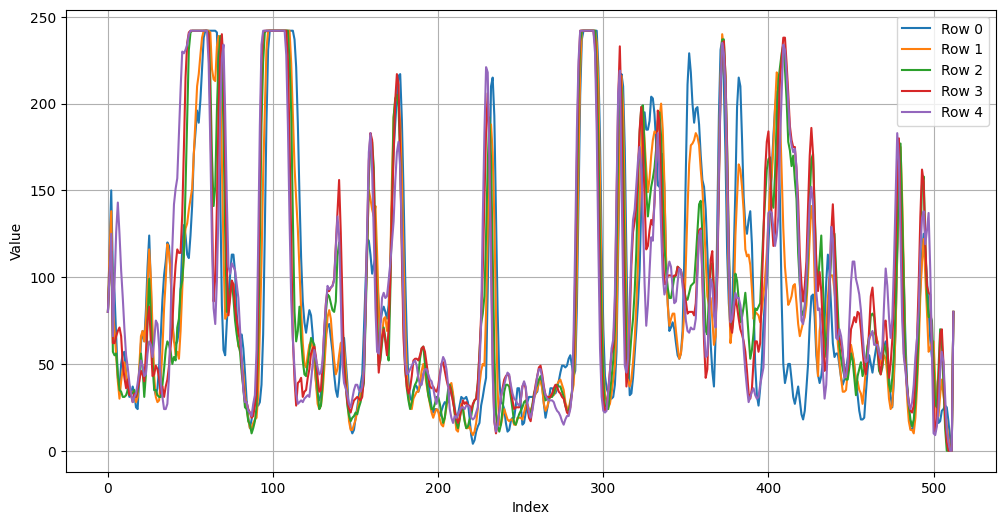

In [5]:
# TODO find peaks test cell #################################################################################################### 
# check variable correctness if the following test point looks good

from scipy.signal import find_peaks, lfilter
import matplotlib.pyplot as plt
from utils import plot_waveforms

spikes_row_prop = np.zeros([numpydilated.shape[0], numpydilated.shape[1]])

for row in range(test_point, test_point + 1):
    peaks, properties = find_peaks(lfilter(cc_b, cc_a, numpydilated[row]), 
                               height       = fp_height,     # like pth
                               # threshold=10,
                               distance     = fp_dist, 
                               prominence   = fp_prominence,
                               wlen         = fp_wlen,
                               rel_height   = fp_rel_height,
                               width        = fp_width)
    
    print(properties)
    for i in range(numpydilated[row].size):
        if i in peaks:
            indices = np.where(peaks == i)
            index = indices[0][0] if indices[0].size > 0 else -1
            spikes_row_prop[row][properties['left_bases'][index]:properties['right_bases'][index]][spikes_row_prop[row][properties['left_bases'][index]:properties['right_bases'][index]] == 0] = 100
            print(i, (i - int(properties['widths'][index]/2), i + int(properties['widths'][index]/2)))
            spikes_row_prop[row][i - int(properties['widths'][index]/2):i + int(properties['widths'][index]/2)] = 255
        # else:
        #     spikes_row[row][i] = 0

test_image = numpydilated.copy()
test_image[test_point - 1, :] = 255

npToImg([[test_image, "Test image row"]])

# Plotting results
plt.figure(figsize=(14, 7))

# Original data
x = np.linspace(0, width, width)
y = lfilter(cc_b, cc_a, numpydilated[test_point])
plt.plot(x, numpydilated[test_point], label='Original Data')
plt.plot(x, lfilter(cc_b, cc_a, numpydilated[test_point]), label='Filtered Data')
plt.plot(x, spikes_row_prop[test_point], label='Widths')
# plt.plot(x, spikes_row_prop[151], label='Original Data')

# Derivative method spikes
plt.scatter(x[peaks], y[peaks], color='green', label='Spikes')

plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.title('spike detection using scipy.find_peaks method')
plt.show()

test_filtered = np.zeros_like(numpydilated)
for i in range(test_point, test_point + 5):
    test_filtered[i] = lfilter(cc_b, cc_a, numpydilated[i])
plot_waveforms(numpydilated[test_point:test_point + 5, :])
plot_waveforms(test_filtered[test_point:test_point + 5, :])

/var/folders/xw/z_ky_mj12wxdnzbkt7q7hmvw0000gn/T/ipykernel_59856/3037110252.py:9: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = find_peaks(lfilter(cc_b, cc_a, matrix[row]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)


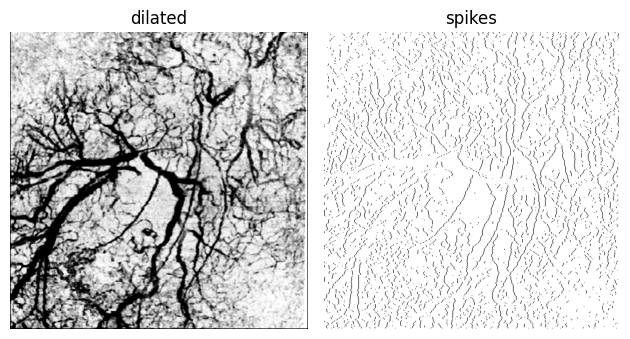

In [6]:
# find row peaks --- good one :) ---------------------------------------------------------------------------------------------------------

matrix = numpydilated.copy()

spikes_row = np.zeros([width, height])
spikes_row_width = np.zeros([width, height])

for row in range(width):
    peaks, properties = find_peaks(lfilter(cc_b, cc_a, matrix[row]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)

    for i in peaks:
        indices = np.where(peaks == i)
        index = indices[0][0] if indices[0].size > 0 else -1
        spikes_row[row][i] = properties['widths'][index]
        w = int(properties['widths'][index] / 2)
        # spikes_row_width[row][max(0, i - w):min(width, i + w + 1)] = matrix[row][max(0, i - w):min(width, i + w + 1)]
        
npToImg([[numpydilated, "dilated"], [np.where(spikes_row[:, :] > 0, 255, 0), "spikes"]])

/var/folders/xw/z_ky_mj12wxdnzbkt7q7hmvw0000gn/T/ipykernel_59856/2396673111.py:10: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = find_peaks(lfilter(cc_b, cc_a, matrix[row]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)


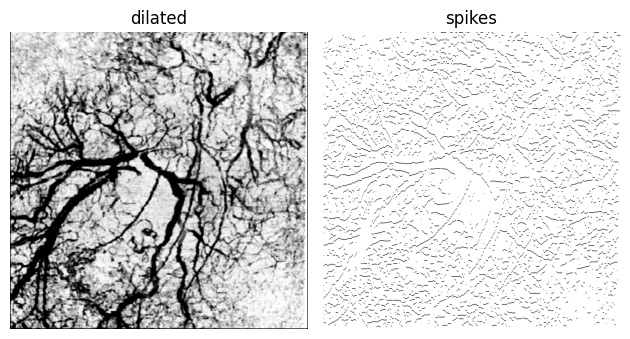

In [7]:
# find column peaks --- good one :) -------------------------------------------------------------------------------------------------------

# transpose matrix to keep the above logic
matrix = numpydilated.T.copy()

spikes_col = np.zeros([width, height])
spikes_col_width = np.zeros([width, height])

for row in range(width):
    peaks, properties = find_peaks(lfilter(cc_b, cc_a, matrix[row]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)

    for i in peaks:
        indices = np.where(peaks == i)
        index = indices[0][0] if indices[0].size > 0 else -1
        spikes_col[row][i] = properties['widths'][index]
        w = int(properties['widths'][index] / 2)
        # spikes_col_width[row][max(0, i - w):min(width, i + w + 1)] = matrix[row][max(0, i - w):min(width, i + w + 1)]
        
spikes_col = spikes_col.T
spikes_col_width = spikes_col_width.T        
        
npToImg([[numpydilated, "dilated"], [np.where(spikes_col[:, :] > 0, 255, 0), "spikes"]])

/var/folders/xw/z_ky_mj12wxdnzbkt7q7hmvw0000gn/T/ipykernel_59856/1822159381.py:14: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, properties = find_peaks(lfilter(cc_b, cc_a, diags_l[d]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)


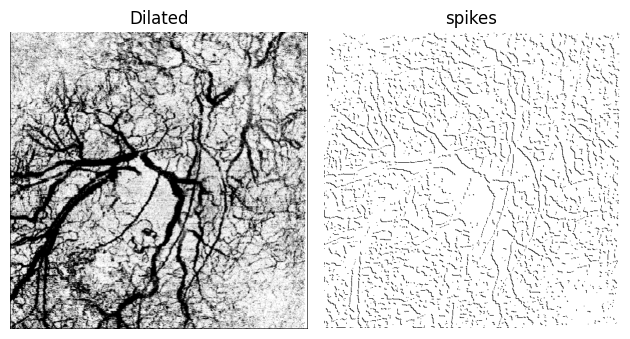

In [8]:
# find left diagonal peaks --- good one :) ------------------------------------------------------------------------------------------------------

from utils import get_coords_from_diags

matrix = numpydilated.copy()

# get diagonal lists
diags_l = [matrix[::-1,:].diagonal(i) for i in range(-width+1, height)]

spikes_diag_l = np.zeros([width, height])
spikes_diag_l_width = np.zeros([width, height])

for d in range(len(diags_l)):
    peaks, properties = find_peaks(lfilter(cc_b, cc_a, diags_l[d]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)

    for i in peaks:
        x, y = get_coords_from_diags(width, d, i)
        indices = np.where(peaks == i)
        index = indices[0][0] if indices[0].size > 0 else -1
        spikes_diag_l[x][y] = properties['widths'][index]
        w = int(properties['widths'][index] / 2)

npToImg([[numpydata, "Dilated"], [np.where(spikes_diag_l[:, :] > 0, 255, 0), "spikes"]])

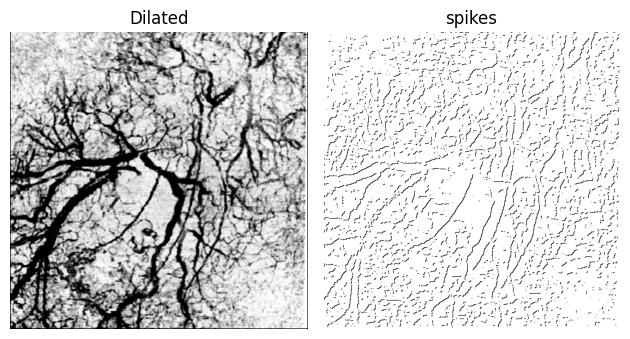

In [9]:
# find right diagonal peaks --- good one :) ------------------------------------------------------------------------------------------------------
 
matrix = numpydilated.copy()

# get diagonal lists
matrix = np.rot90(matrix, k=1)
diags_r = [matrix[::-1,:].diagonal(i) for i in range(-width+1, height)]

spikes_diag_r = np.zeros([width, height])
spikes_diag_r_width = np.zeros([width, height])

for d in range(len(diags_r)):
    peaks, properties = find_peaks(lfilter(cc_b, cc_a, diags_r[d]), distance=fp_dist, prominence=fp_prominence, wlen=fp_wlen, rel_height=fp_rel_height, width=fp_width)

    for i in peaks:
        x, y = get_coords_from_diags(width, d, i)
        indices = np.where(peaks == i)
        index = indices[0][0] if indices[0].size > 0 else -1
        spikes_diag_r[x][y] = properties['widths'][index]
        w = int(properties['widths'][index] / 2)

spikes_diag_r = np.rot90(spikes_diag_r, k=3, axes=(0, 1))

npToImg([[numpydilated, "Dilated"], [np.where(spikes_diag_r[:, :] > 0, 255, 0), "spikes"]])

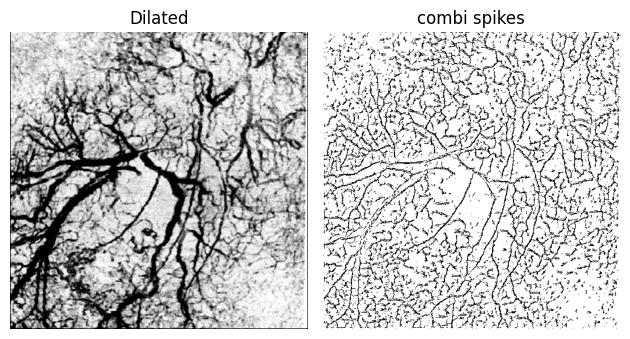

spikes-combi (513, 513)


In [10]:
# keep all peaks in the following variable 
# if two are in same place keep the minWidth
# :0 direction: 1 - row / 2 - col / 3 - left diagonal / 4 - right diagonal
# :1 width
# :2 cross correlation value 
# :3 depth in volume
# :4 image 0 real value
spikes_combi = np.zeros([width, height, 5])

for i in range(width):
    for j in range(height):
        min_width = [255, 0, 0, 0, 0]
        if 0 < spikes_row[i, j] < min_width[0]:
            min_width = [1, spikes_row[i, j], 0, 0, 0]
        if 0 < spikes_col[i, j] < min_width[0]:
            min_width = [2, spikes_col[i, j], 0, 0, 0]
        if 0 < spikes_diag_l[i, j] < min_width[0]:
            min_width = [3, spikes_diag_l[i, j], 0, 0, 0]
        if 0 < spikes_diag_r[i, j] < min_width[0]:
            min_width = [4, spikes_diag_r[i, j], 0, 0, 0]
            
        if min_width[0] == 255:
            spikes_combi[i, j] = [0, 0, 0, 0, 0]
        else:
            spikes_combi[i, j] = min_width

npToImg([[numpydilated, "Dilated"], [np.where(np.logical_and(spikes_combi[:, :, 0] > 0, spikes_combi[:, :, 1] > 0), 255, 0), "combi spikes"]])

# save img
npSaveImg(np.where(np.logical_and(spikes_combi[:, :, 0] > 0, spikes_combi[:, :, 1] > 0), 255, 0), out_dir, "spikes-combi") 


## Filter for len and cross correlation -----------

In [11]:
# fill spikes_combi with the cross correlation

from correlation import cross_correlation

for i in range(width):
    for j in range(height):
        if spikes_combi[i, j, 1] > 0 and (spikes_combi[i, j, 0] == 1 or spikes_combi[i, j, 0] == 2):
            cc = cross_correlation(numpydilated, spikes_combi[:, :, 1], i, j, spikes_combi[i, j, 0])
            spikes_combi[i, j, 2] = cc 


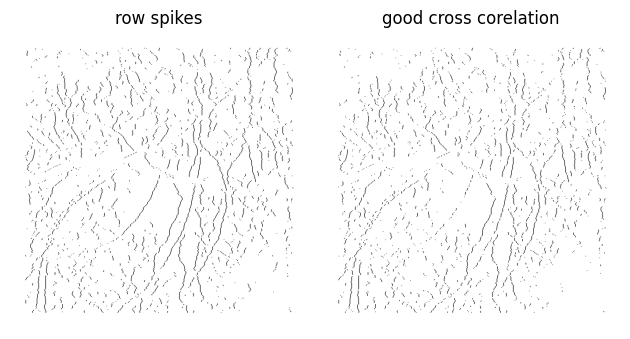

In [12]:
npToImg([[np.where(np.logical_and(spikes_combi[:, :, 2] > 0, spikes_combi[:, :, 0] == 1), 255, 0), "row spikes"], [np.where(np.logical_and(spikes_combi[:, :, 2] > 0.8, spikes_combi[:, :, 0] == 1), 255, 0), "good cross corelation"]])

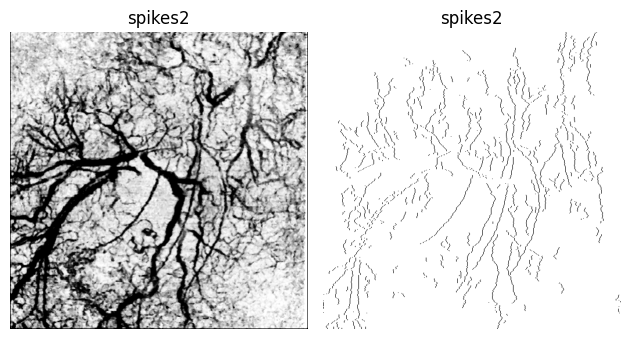

In [13]:
# filter for continuous row peaks -------------------------------------------------------------

from connected import check 

# path length and cross correlation constants -------------------------------------------------------------
# default_path_length = 15
# default_cc_tresh = 0.8
# default_cc_length = 2

# localpeaks = founded_peaks.copy()
matrix = spikes_row.copy()
# keep local spikes till the matrix is processed
local_spikes = []
local_spikes_row = np.zeros([width, height])

for i in range(matrix.shape[0]): #
    # for each row check if there is any spike and find connected
    row_spikes = np.where(matrix[i, :] > 0)[0]
    for j in row_spikes:
        if (i, j) not in local_spikes:
            path = []
            gaps = []
            path.append((i, j))
            window = int(matrix[i, j] / 2) # 5
            paths, gapps = check(spikes_row, spikes_row, i, j, window, path, gaps)
            if len(paths) > 0: #default_path_length:
                ccc = []
                for x, y in paths:
                    cc = cross_correlation(numpydilated, matrix, x, y, 1)
                    ccc.append(cc)
                    # if x in [81, 82, 83, 84, 85] and y < 151:
                    #     print(x, y, cc)
                    # spikes_combi[x, y, 3] = cc
                min_cc_length = max(cc_length, int(len(paths + gapps) / 2))
                if sum(1 for i in ccc if i > cc_tresh) > min_cc_length:
                    local_spikes = local_spikes + paths + gapps

# keep local spikes to not alter spikes_row till whole matrix is processed
for i, j in local_spikes:
    local_spikes_row[i][j] = 255

npToImg([[numpydilated, "spikes2"], [local_spikes_row[:, :], "spikes2"]])

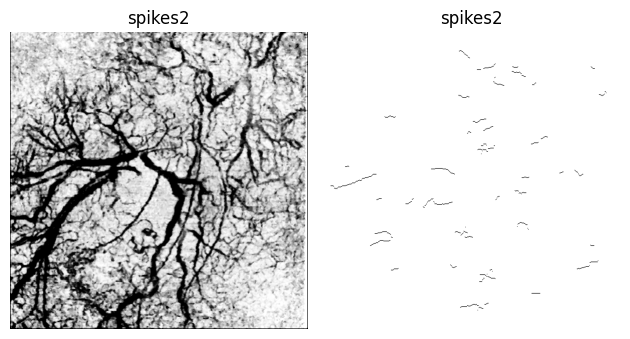

In [14]:
# filter for continuous col peaks -------------------------------------------------------------

# path length and cross correlation constants -------------------------------------------------------------
# default_path_length = 15
# default_cc_tresh = 0.9
# default_cc_length = 2

matrix = spikes_col.T.copy()
# keep local spikes till the matrix is processed
local_spikes = []
local_spikes_col = np.zeros([width, height])

# npToImg([[numpydilated, "spikes2"], [local_spikes_col[:, :], "spikes2"]

for i in range(matrix.shape[0]): #
    # for each row check if there is any spike and find connected
    row_spikes = np.where(matrix[i, :] > 0)[0]
    for j in row_spikes:
        if (i, j) not in local_spikes:
            path = []
            gaps = []
            path.append((i, j))
            window = int(matrix[i, j] / 2) # 5
            paths, gapps = check(matrix, matrix, i, j, window, path, gaps)
            if len(paths) > 0: #default_path_length:
                ccc = []
                for x, y in paths:
                    cc = cross_correlation(numpydilated, matrix, x, y, 1)
                    ccc.append(cc)
                    # spikes_combi[x, y, 3] = cc
                min_cc_length = max(cc_length, int(len(paths + gapps) / 2))
                if sum(1 for i in ccc if i > cc_tresh) > min_cc_length:
                    local_spikes = local_spikes + paths + gapps

# keep local spikes to not alter spikes_row till whole matrix is processed
for i, j in local_spikes:
    local_spikes_col[i][j] = 255

local_spikes_col = local_spikes_col.T

npToImg([[numpydilated, "spikes2"], [local_spikes_col[:, :], "spikes2"]])

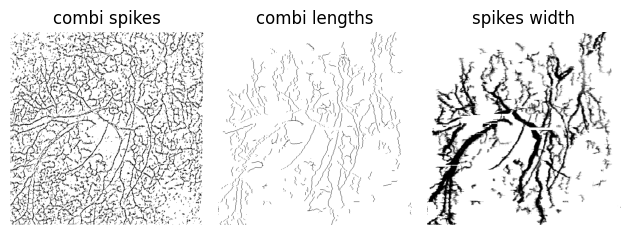

founded-lengths (513, 513)


In [15]:
# combined after filter by row/col length -------------------------------------------------------------
founded_lengths = np.maximum(local_spikes_row[:, :], local_spikes_col[:, :])
# npToImg([[founded_lengths, "combined lengths"], [founded_peaks, "founded peaks"]])

spikes_width = np.zeros([numpydilated.shape[0], numpydilated.shape[1]])

# test to get the width aprox
for i in range(numpydilated.shape[0]):
    for j in range(numpydilated.shape[1]):
        if local_spikes_row[i, j] > 100:
            lw = int(spikes_row[i, j] / 2)
            spikes_width[i][max(0, j - lw):min(width, j + lw + 1)] = numpydilated[i][max(0, j - lw):min(width, j + lw + 1)]
        if local_spikes_col[i, j] > 100:
            lh = int(spikes_col[i, j] / 2)
            spikes_width[max(0, i - lh):min(height, i + lh + 1), j] = numpydilated[max(0, i - lh):min(height, i + lh + 1), j]
        
npToImg([[np.where(np.logical_and(spikes_combi[:, :, 0] > 0, spikes_combi[:, :, 1] > 0), 255, 0), "combi spikes"], [founded_lengths, "combi lengths"], [spikes_width, "spikes width"]])

cropperddata = np.where(spikes_width > 0, numpydata, 0)

npSaveImg(founded_lengths[:, :], out_dir, "founded-lengths")

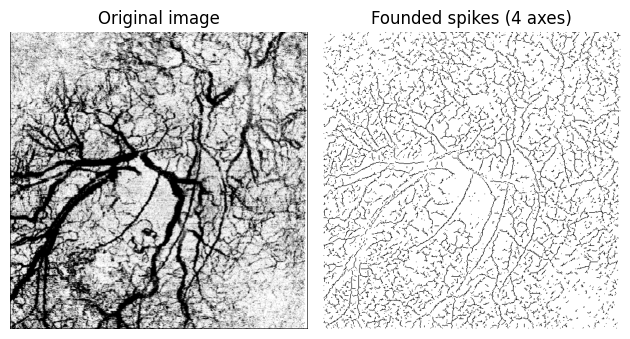

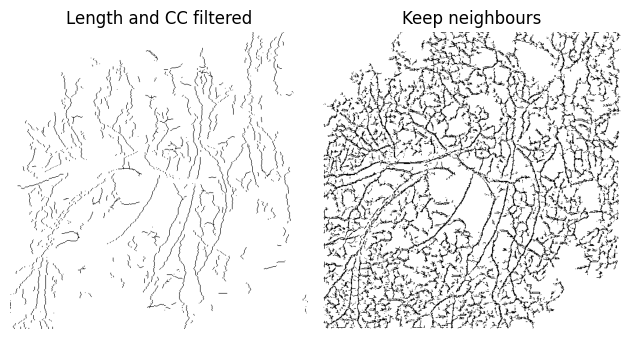

In [16]:
# get all connected neighbours 
# founded_lengths / all good/trusted peaks
# spikes_combi / all peaks in 3d

neighbour_spikes_combi = np.zeros([width, height, 5])
sys.setrecursionlimit(150000)

# good neighbour function ---  but not used :)
def get_neighbors(matrix, x, y, size=7):
    if size % 2 == 0:
        raise ValueError("Size must be an odd number")

    radius = size // 2
    
    neighbors = []
    rows, cols = len(matrix), len(matrix[0])
    
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            if dx == 0 and dy == 0:
                continue  # Skip the center point itself
            
            nx, ny = x + dx, y + dy
            
            # Check if the new coordinates are within the bounds of the matrix
            if 0 <= nx < rows and 0 <= ny < cols:
                if matrix[nx][ny] > 0: # check if is a peak
                    neighbors.append((nx, ny))
    
    return neighbors

def check_neighbour(i, j):
    global spikes_combi
    global neighbour_spikes_combi
    for x, y in get_neighbors(spikes_combi[:, :, 0], i, j):
        if neighbour_spikes_combi[x, y, 0] == 0:
            neighbour_spikes_combi[x, y] = spikes_combi[x, y]
            check_neighbour(x, y)

for i in range(width):
    for j in range(height):
        if founded_lengths[i, j] > 0:
            check_neighbour(i, j)
                
npToImg([[numpydata, "Original image"], [np.where(np.logical_or(spikes_combi[:, :, 0] == 1, spikes_combi[:, :, 0] == 2), 255, 0), "Founded spikes (4 axes)"]])
npToImg([[founded_lengths, "Length and CC filtered"], [np.where(neighbour_spikes_combi[:, :, 0] > 0, 255, 0), "Keep neighbours"]])
            

# save img
# npSaveImg(np.where(np.logical_and(spikes_combi[:, :, 0] > 0, spikes_combi[:, :, 1] > 0), 255, 0), out_dir, "spikes-combi") 



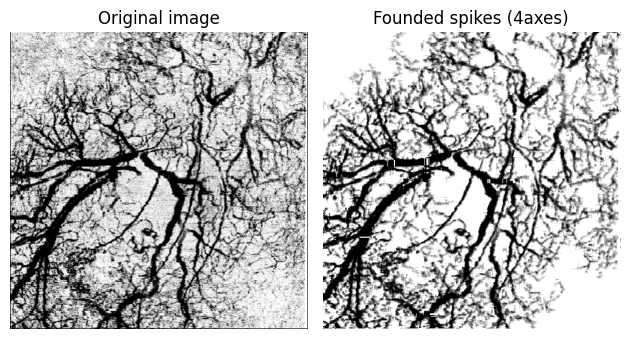

In [17]:
# get the corresponding width and height
matrix = neighbour_spikes_combi.copy()
for x, y in zip(*np.where(matrix[:, :, 0] > 0)):
    direction = matrix[x, y, 0]
    window = int(matrix[x, y, 1] / 2)

    if direction == 1:
        matrix[x, max(0, y - window):min(matrix.shape[1], y + window + 1), 4] = numpydilated[x, max(0, y - window):min(matrix.shape[1], y + window + 1)]
    elif direction == 2:
        matrix[max(0, x - window):min(matrix.shape[0], x + window + 1), y, 4] = numpydilated[max(0, x - window):min(matrix.shape[0], x + window + 1), y]
        
neighbour_spikes_combi = matrix.copy()
        
npToImg([[numpydata, "Original image"], [np.where(matrix[:, :, 4] == 0, 0, matrix[:, :, 4]), "Founded spikes (4axes)"]])

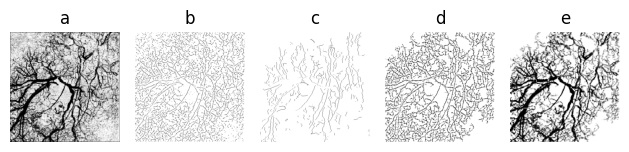

In [18]:
npToImg([[numpydata, "a"], [np.where(np.logical_or(spikes_combi[:, :, 0] == 1, spikes_combi[:, :, 0] == 2), 255, 0), "b"],[founded_lengths, "c"], [np.where(neighbour_spikes_combi[:, :, 0] > 0, 255, 0), "d"], [np.where(matrix[:, :, 4] == 0, 0, matrix[:, :, 4]), "e"]])

## Get the main point in stack
process all images and try to identify the main vessel point in volume

In [19]:
# --- load all oct images, crop -----------------------------------------------------------------------------
imgs = [];

for i in range(img_no):
    full_img = Image.open(base_dir + str( i + 1 ) + '.png').convert('L')
    npData = np.array(full_img)
    imgs.append(median_filter(crop(npData, crop_h1, crop_h2, crop_w1, crop_w2), 3))

imgs = np.asarray(imgs)

# crop and eliminate noise outside mask 
threeD_obj = np.empty((width, height, img_no), dtype=np.uint8);
threeD_img = np.empty((img_no, width, height), dtype=np.uint8);

for i in range(img_no):
    # for x in range(imgs[i].shape[0]):
    #     for y in range(imgs[i].shape[1]):
    #         # TODO eliminate noise here
    # 
    #         if neighbour_spikes_combi[x, y, 4] < 1:
    #             imgs[i, x, y] = 0 

            # threeD_obj[x][y][i] = imgs[i][x][y]
            # threeD_img[i][x][y] = imgs[i][x][y]
    npSaveImg(median_filter(imgs[i], 5), out_dir, str(i) + ".png")
            
arrReshaped = imgs.reshape(imgs.shape[0], -1)
np.savetxt(out_dir + 'threeD_img.csv', arrReshaped)

0.png (513, 513)
1.png (513, 513)
2.png (513, 513)
3.png (513, 513)
4.png (513, 513)
5.png (513, 513)
6.png (513, 513)
7.png (513, 513)
8.png (513, 513)
9.png (513, 513)
10.png (513, 513)
11.png (513, 513)
12.png (513, 513)
13.png (513, 513)
14.png (513, 513)
15.png (513, 513)
16.png (513, 513)
17.png (513, 513)
18.png (513, 513)
19.png (513, 513)
20.png (513, 513)
21.png (513, 513)
22.png (513, 513)
23.png (513, 513)
24.png (513, 513)
25.png (513, 513)
26.png (513, 513)
27.png (513, 513)
28.png (513, 513)
29.png (513, 513)
30.png (513, 513)
31.png (513, 513)
32.png (513, 513)
33.png (513, 513)
34.png (513, 513)
35.png (513, 513)
36.png (513, 513)
37.png (513, 513)
38.png (513, 513)
39.png (513, 513)
40.png (513, 513)
41.png (513, 513)
42.png (513, 513)
43.png (513, 513)
44.png (513, 513)
45.png (513, 513)
46.png (513, 513)
47.png (513, 513)
48.png (513, 513)
49.png (513, 513)
50.png (513, 513)
51.png (513, 513)
52.png (513, 513)
53.png (513, 513)
54.png (513, 513)
55.png (513, 513)
56

In [20]:
# npToImg([[ imgs[16, :, :], "section 16"], [imgs[32, :, :], "section 32"], [imgs[48, :, :], "section 48"]])

## Try to identify the most intense zone in depth
use a circle kernel and apply to the middle of the image 

not soo good because the blod vessel can have a different shape than a round one, so it's better to keep the intensity neighbours ( and maybe try to get a smoothing library to wrap up everything together ? )

## 1st method with kernel -----

In [21]:
# define the circle kernel
def circle_kernel_2d(n):
    if n < 5:
        return np.full((n, n), 5) 
    r = (n - 1) / 2.0
    y, x = np.ogrid[-r:r+1, -r:r+1]
    distance = np.sqrt(x**2 + y**2)
    kernel = np.full((n, n), 0)
    
    # Fill the circle with increasing intensity based on depth from the surface
    for i in range(int(r), -1, -1):
        mask = (distance <= i)
        kernel[mask] = int(r) * int(r) - i * 2 + 1
    
    # Fill outside the circle with decreasing intensity (negative values)
    # de la 2-3 la 0-1
    # for i in range(int(r) + 1, n):
    #     mask = (distance > i - 1)
    #     kernel[mask] = -(i - int(r))
    
    return kernel

def circle_kernel_3d(n):
    r = (n - 1) / 2.0
    z, y, x = np.ogrid[-r:r+1, -r:r+1, -r:r+1]
    distance = np.sqrt(x**2 + y**2 + z**2)
    kernel = np.full((n, n, n), 0)
    
    # Fill the sphere with increasing intensity based on depth from the surface
    for i in range(int(r), -1, -1):
        mask = (distance <= i)
        kernel[mask] = int(r)*int(r) - i*2 + 1
        
    # # Fill outside the sphere with decreasing intensity (negative values)
    # for i in range(int(r) + 1, n):
    #     mask = (distance > i - 1)
    #     kernel[mask] = -(i - int(r))
    
    return kernel

# apply a square kernel with a circle positive values to the image height and get the most intense point
def most_intense_zone(image_to_process, kernel = None, ref = None):
    shape = len(image_to_process.shape)
    if kernel is None:
        if shape == 2:
            kernel = circle_kernel_2d(int(image_to_process.shape[1])) # 2D
        else:
            kernel = circle_kernel_3d(int(image_to_process.shape[1])) # 3D
    
    kernel_img = np.zeros([image_to_process.shape[0]])
    
    for r in range(window, image_to_process.shape[0]-window-1):
        # Extract a window of pixels around the current pixel
        tmp = int(kernel.shape[0]/2)
        
        if shape == 2:
            px_window = image_to_process[r-tmp:r+tmp+1,:] # 2D
        else:
            px_window = image_to_process[r-tmp:r+tmp+1,:,:] # 3D
        kernel_img[r] = int((px_window * kernel).sum())
        
    if ref is not None: 
        return kernel_img[max(ref-10, 0):min(ref+11, image_to_process.shape[0])].argmax() + max(ref-10, 0) 
    return kernel_img.argmax()

# apply a square kernel with a circle positive values to the image height and get the most intense point
def most_intense_zone_3D(image_to_process, kernel = None, ref = None):
    kernel_img = np.zeros([img_no])
    for r in range(3, image_to_process.shape[0] - 3):
        # px_window = image_to_process[r-tmp:r+tmp+1,:,:] # 3D
        px_window = image_to_process[r-2:r+3, :, :] # 2D
        kernel_img[r] = int((px_window * [kernel, kernel, kernel, kernel, kernel]).sum())
        
    if ref is not None: 
        return kernel_img[max(ref-10, 0):min(ref+11, image_to_process.shape[0])].argmax() + max(ref-10, 0) 
    return kernel_img.argmax()

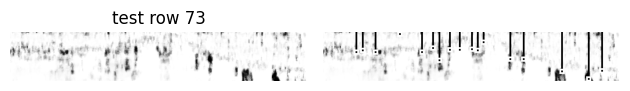

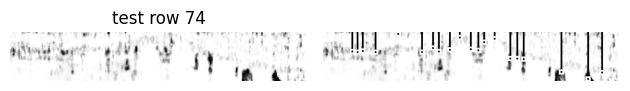

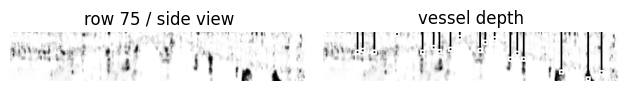

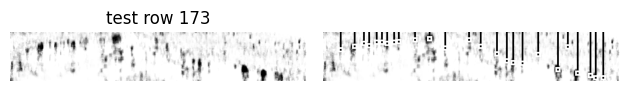

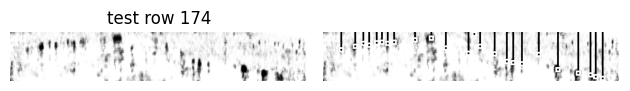

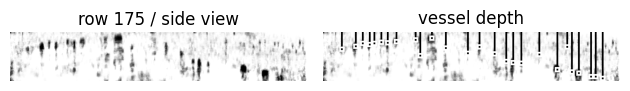

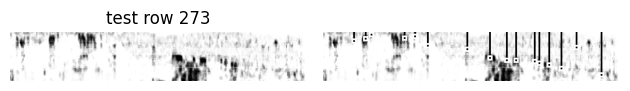

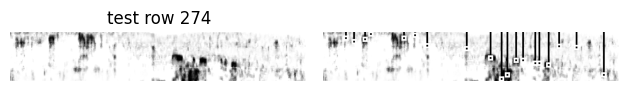

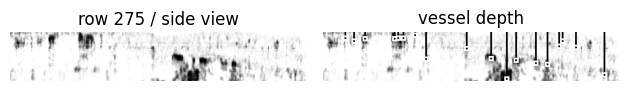

In [22]:
# 2D kernel test on 4 axes 
# maybe one alternative to kernel will be cv2.minMaxLoc / not tested 
import scipy.ndimage

# get a window from main image and convolve each slice to see where is the best match
# good results, few missmatch 

# acuratetea din prima e mult mai buna, 9.5 - 9.75/10
# si pentru corectare
# de la kernel mic la mare, nu s a prea schimbat
# de la kernel mic la mare, nu s a prea schimbat

from utils import get_diags_from_coords, get_coords_from_diags

neighbour_spikes_combi[:, :, 3] = 0

matrix = neighbour_spikes_combi.copy()
result = neighbour_spikes_combi.copy()
imgs2 = imgs.copy()

# for x, y in zip(*np.where(matrix[:, :, 1] > 0)):
for x,y in zip(*np.where(matrix[:, :, 0] > 0)):
    # if x == 131 or x == 132 or x == 133:

    image_to_process = np.zeros((img_no, width), dtype=np.uint8)
    window = int(matrix[x, y, 1])

    if 25 < x < matrix.shape[0] - 25 and 25 < y < matrix.shape[1] - 25:
        direction = matrix[x, y, 0]
        image_to_process = imgs[:, max(0, x - window):min(matrix.shape[1], x + window + 1), max(0, y - window):min(matrix.shape[1], y + window + 1)]

        if np.all(image_to_process == 0):
            continue    

        kernel = neighbour_spikes_combi[max(0, x-window):min(x+window+1, height), max(0, y-window):min(y+window+1, width), 4]

        index = most_intense_zone_3D(image_to_process, kernel)
        result[x, y, 3] = index # store the max intense point depth

        # testing only 
        # for 2d_kernel ###
        if direction == 1:
            imgs2[0:min(img_no, index+4+1), x, max(0, y - 1):min(matrix.shape[1], y + 1 + 1)] = 255
            imgs2[max(0, index-4):min(img_no, index+4+1), x, max(0, y - 4):min(matrix.shape[1], y + 4 + 1)] = 0
            imgs2[max(0, index-1):min(img_no, index+1+1), x, max(0, y - 1):min(matrix.shape[1], y + 1 + 1)] = 255
        # for 3d_kernel ###
        # imgs2[max(0, index-2):min(img_no, index+2+1), max(0, x-2):min(matrix.shape[0], x+2+1), max(0, y - 2):min(matrix.shape[1], y + 2 + 1)] = 255

npToImg([[ imgs[:, 73, :], "test row 73"], [imgs2[:, 73, :], ""]])
npToImg([[ imgs[:, 74, :], "test row 74"], [imgs2[:, 74, :], ""]])
npToImg([[ imgs[:, 75, :], "row 75 / side view"], [imgs2[:, 75, :], "vessel depth"]])
npToImg([[ imgs[:, 173, :], "test row 173"], [imgs2[:, 173, :], ""]])
npToImg([[ imgs[:, 174, :], "test row 174"], [imgs2[:, 174, :], ""]])
npToImg([[ imgs[:, 175, :], "row 175 / side view"], [imgs2[:, 175, :], "vessel depth"]])
npToImg([[ imgs[:, 273, :], "test row 273"], [imgs2[:, 273, :], ""]])
npToImg([[ imgs[:, 274, :], "test row 274"], [imgs2[:, 274, :], ""]])
npToImg([[ imgs[:, 275, :], "row 275 / side view"], [imgs2[:, 275, :], "vessel depth"]])

threeD_img_filtered = np.zeros((img_no, width, height), dtype=np.uint8)
for x, y in zip(*np.where(result[:, :, 3] > 0)):
    depth = int(result[x, y, 3])
    threeD_img_filtered[depth, x, y] = 255

arrReshaped = threeD_img_filtered.reshape(threeD_img_filtered.shape[0], -1)
np.savetxt(out_dir + 'kernel_2d_mask.csv', arrReshaped)

neighbour_spikes_combi = result

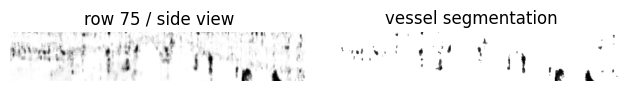

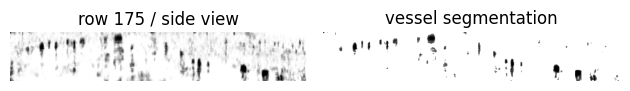

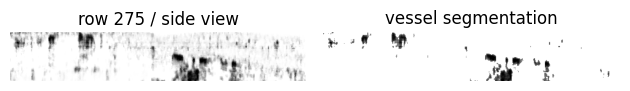

In [25]:
# TODO last one good to go --------------------------------------------------------
from neighbours_intensity import neighboursIntensity3D

# def find_centroids(values):
#     values = np.array(values).reshape(-1, 1)
#     kmeans = KMeans(n_clusters=2, random_state=0).fit(values)
#     centroids = kmeans.cluster_centers_.flatten()
#     return np.mean(centroids)

from utils import percentile
from skimage.morphology import square, opening, remove_small_objects
import cv2

threeD_img_scanned = np.zeros((img_no, width, height), dtype=np.uint8);
matrix = neighbour_spikes_combi.copy()

for x, y in zip(*np.where(matrix[:, :, 0] > 0)):
    window = int(matrix[x, y, 1])
    depth = int(matrix[x, y, 3])
    image_to_process = imgs[max(0, depth-window):min(img_no, depth+window+1), max(0, x-window):min(matrix.shape[0], x+window+1), max(0, y - window):min(matrix.shape[1], y + window + 1)].copy()
    # tresh_window = 2
    # image_to_process_tresh = imgs[max(0, depth-tresh_window):min(img_no, depth+tresh_window+1), max(0, x-tresh_window):min(matrix.shape[0], x+tresh_window+1), max(0, y - tresh_window):min(matrix.shape[1], y + tresh_window + 1)].copy()
    tresh = 120 # best fitting and fastest for testing / consider dbscan for a better accuracy
    # tresh = max(120, imgs[depth, x, y] - 5)
    # flt = image_to_process.copy()
    # tresh = get_tresh(flt, 10)
    # tresh = max(120, np.min(image_to_process_tresh)) 
    # tresh = np.mean(image_to_process_tresh) 
    # tresh = find_centroids(image_to_process.flatten())
    # tresh = percentile(image_to_process, 90)
    # tresh = find_centroids(image_to_process_tresh.mean())
    
    
    
    # # if x == 209 or x == 210:
    # db_tresh, min_t = 0, 0
    # iii = get_2d_img(x, y)
    # iii = iii[iii != 0]
    # # print(len(iii))
    # # print(iii)
    # if len(iii) > 5:
    #     tresh = min_tresh(iii, 3, window)
    # else:
    #     tresh = 120
    # # db_tresh = max(120, min_t)
    # # print(x, y, min_t)
    # # tresh = max(120, min_t)
    
    mask = image_to_process > tresh
    final_image = np.where(mask, image_to_process, 0)
        
    # final_image = dbscan(final_image)
    # final_image = opening(final_image, square(3))
    
    threeD_img_scanned[max(0, depth-window):min(img_no, depth+window+1), max(0, x-window):min(matrix.shape[0], x+window+1), max(0, y - window):min(matrix.shape[1], y + window + 1)] = final_image.copy()
    
# threeD_img_scanned = remove_small_objects(threeD_img_scanned, min_size=width ** 30)

npToImg([[ imgs[:, 75, :], "row 75 / side view"], [threeD_img_scanned[:, 75, :], "vessel segmentation"]])
npToImg([[ imgs[:, 175, :], "row 175 / side view"], [threeD_img_scanned[:, 175, :], "vessel segmentation"]])
npToImg([[ imgs[:, 275, :], "row 275 / side view"], [threeD_img_scanned[:, 275, :], "vessel segmentation"]])

# npToImg([[ imgs[:, 75, :], "test row 75"], [threeD_img_scanned[:, 75, :], ""]])
# npToImg([[ imgs[:, 175, :], "test row 175"], [threeD_img_scanned[:, 175, :], ""]])
# npToImg([[ imgs[:, 275, :], "test row 275"], [threeD_img_scanned[:, 275, :], ""]])
# imex = threeD_img_scanned[:, 275, :]
# kernel = np.ones((3, 3), np.uint8) 
# # imex = median_filter(imex, 0.5) 
# imex = opening(imex, square(5))
# 
# # remove_objects = remove_small_objects(threeD_img_scanned, min_size=5 ** 3, connectivity=500)
# # threeD_img_scanned = remove_objects 
# 
# npToImg([[ imgs[:, 275, :], "test row 275"], [threeD_img_scanned[:, 275, :], ""]])
   
arrReshaped = threeD_img_scanned.reshape(threeD_img_scanned.shape[0], -1)
np.savetxt(out_dir + 'kernel_scanned.csv', arrReshaped)

In [28]:
count = np.count_nonzero(threeD_img_scanned > 0)
print("Number of founded pixels to be part of a blood vessel ( ±5% err ):", count)

# 1px = 5.7 x 5.7 (radial) x 3.9 (axial)
# px_vol = 5.7 * 5.7 * 25
px_vol = 5.54 * 5.54 * 25
print(px_vol)
estimate_volume = count * px_vol
estimate_volume_mm = estimate_volume / 1e9
print('Formula: pixel dimension given by the manufactured in µm: 5.7(width) * 5.7(height) * 3.9(depth) = 126.711(µm³)')
print('The depth image set was exported at a thickness of 25µm, with the beginning of each section continuing from the previous one, resulting in the following dimensions for one voxel ( pixel with depth ): 5.54(width) * 5.54(height) * 25(thickness) = ' + str(px_vol) + '(µm³)')
print('Estimated volume: ' + str(estimate_volume) + 'µm³, or ' + str(estimate_volume_mm) + 'mm³') 

Number of founded pixels to be part of a blood vessel ( ±5% err ): 1121580
767.2900000000001
Formula: pixel dimension given by the manufactured in µm: 5.7(width) * 5.7(height) * 3.9(depth) = 126.711(µm³)
The depth image set was exported at a thickness of 25µm, with the beginning of each section continuing from the previous one, resulting in the following dimensions for one voxel ( pixel with depth ): 5.54(width) * 5.54(height) * 25(thickness) = 767.2900000000001(µm³)
Estimated volume: 860577118.2µm³, or 0.8605771182mm³
